In [37]:
# from google.colab import drive
# drive.mount('/content/drive')
# root_path = '/content/drive/MyDrive/CSC2547/project'
 
import os
# os.getcwd()
# os.chdir(root_path)

In [38]:
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from learn import DRRTrainer
from utils.general import csv_plot
import torch
import pickle
import numpy as np
import random
import os
import datetime

import matplotlib.pyplot as plt
 
%matplotlib inline

In [39]:
class config():
    output_path = 'results/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S') + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plot_dir = output_path + 'rewards.pdf'
 
    train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
    train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
    train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'
 
    train_actor_loss_plot_dir = output_path + 'train_actor_loss.png'
    train_critic_loss_plot_dir = output_path + 'train_critic_loss.png'
    train_mean_reward_plot_dir = output_path + 'train_mean_reward.png'
 
    trained_models_dir = 'dataset/data_runs/'
 
    actor_model_trained = trained_models_dir + 'actor_net.weights'
    critic_model_trained = trained_models_dir + 'critic_net.weights'
    state_rep_model_trained = trained_models_dir + 'state_rep_net.weights'
 
    actor_model_dir = output_path + 'actor_net.weights'
    critic_model_dir = output_path + 'critic_net.weights'
    state_rep_model_dir = output_path + 'state_rep_net.weights'
 
    csv_dir = output_path + 'log.csv'
 
    path_to_trained_pmf = trained_models_dir + 'ratio_0.800000_bs_100000_e_71_wd_0.100000_lr_0.000100_trained_pmf.pt'
 
    # hyperparams
    batch_size = 64
    gamma = 0.9
    replay_buffer_size = 1000 #100000
    history_buffer_size = 5
    learning_start = 5000
    learning_freq = 1
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    max_timesteps_train = 1000 #260000
    max_epochs_offline = 100 #500
    max_timesteps_online = 2000 #20000
    embedding_feature_size = 100
    episode_length = 10
    train_ratio = 0.8
    weight_decay = 0.01
    clip_val = 1.0
    log_freq = 100
    saving_freq = 1000
    zero_reward = False
 
    no_cuda = True #False

In [40]:
def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)

In [41]:
print("Initializing DRR Framework ----------------------------------------------------------------------------")
 
# Get CUDA device if available
cuda = True if not config.no_cuda and torch.cuda.is_available() else False
print("Using CUDA") if cuda else print("Using CPU")


 
# Init seeds
# seed_all(mps, 0)
seed_all(cuda, 0)
print("Seeds initialized")
 
# Grab models
actor_function = Actor
critic_function = Critic
state_rep_function = DRRAveStateRepresentation
 
# Import Data
users = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
data = np.load('dataset/data_new.npy', allow_pickle=True)

Initializing DRR Framework ----------------------------------------------------------------------------
Using CPU
Seeds initialized


In [46]:
# Normalize rewards to [-1, 1]
data[:, 0] = 0.5 * (data[:, 0] - 3)

data = data[:,:-1] # PMF only need id and stars
data = data.astype(np.float64)
data

array([[ 0.00000e+00,  5.40278e+05,  3.30000e+01,  4.06000e+00,
         8.07390e+04,  3.00000e+00],
       [-5.00000e-01,  6.61290e+04,  3.90000e+01,  3.05000e+00,
         8.07390e+04,  3.00000e+00],
       [ 0.00000e+00,  6.47623e+05,  4.90000e+02,  3.33000e+00,
         8.07390e+04,  3.00000e+00],
       ...,
       [ 1.00000e+00,  2.09320e+05,  1.90000e+01,  4.37000e+00,
         1.44618e+05,  3.00000e+00],
       [ 1.00000e+00,  3.68960e+05,  1.50000e+01,  4.27000e+00,
         9.18410e+04,  5.00000e+00],
       [ 1.00000e+00,  2.01480e+04,  1.30000e+01,  5.00000e+00,
         1.07300e+05,  4.00000e+00]])

In [47]:
# Shuffle data
np.random.shuffle(data)

# Split data
train_data = torch.from_numpy(data[:int(config.train_ratio * data.shape[0])])
test_data = torch.from_numpy(data[int(config.train_ratio * data.shape[0]):])

print("Data imported, shuffled, and split into Train/Test, ratio=", config.train_ratio)
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Data imported, shuffled, and split into Train/Test, ratio= 0.8
Train data shape:  torch.Size([3778726, 6])
Test data shape:  torch.Size([944682, 6])


In [48]:
# Create and load PMF function for rewards and embeddings
n_users = len(users)
n_items = len(items)

reward_function = PMF(n_users, n_items, config.embedding_feature_size, is_sparse=False, no_cuda=~cuda) #~mps
reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)

Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([681956, 100])
Item embeddings shape:  torch.Size([150346, 100])


In [49]:
reward_function

PMF(
  (user_embeddings): Embedding(681956, 100)
  (item_embeddings): Embedding(150346, 100)
  (ub): Embedding(681956, 1)
  (ib): Embedding(150346, 1)
)

In [50]:
cuda

False

In [51]:
# Init trainer
print("Initializing DRRTrainer -------------------------------------------------------------------------------")
trainer = DRRTrainer(config,
                      actor_function,
                      critic_function,
                      state_rep_function,
                      reward_function,
                      users,
                      items,
                      train_data,
                      test_data,
                      user_embeddings,
                      item_embeddings,
                      cuda #mps #cuda
                      )

Initializing DRRTrainer -------------------------------------------------------------------------------
Current PyTorch Device:  cpu
Data dimensions extracted
Models initialized
Model weights initialized, copied to target
Optimizers initialized


In [12]:
from utils.prioritized_replay_buffer import NaivePrioritizedReplayMemory
from utils.history_buffer import HistoryBuffer

In [71]:
train_data = train_data.to(torch.device('cpu'))

# Init buffers
replay_buffer = NaivePrioritizedReplayMemory(config.replay_buffer_size,
                                                     prob_alpha=config.prob_alpha)
history_buffer = HistoryBuffer(config.history_buffer_size)

# Init trackers
timesteps = epoch = 0
eps_slope = abs(config.eps_start - config.eps) / config.eps_steps
eps = config.eps_start
actor_losses = []
critic_losses = []
epi_rewards = []
epi_avg_rewards = []
e_arr = []

# Get users, shuffle, andgo through array
user_idxs = np.array(list(users.values()))
        
np.random.shuffle(user_idxs)

In [73]:
device = torch.device('cpu')

In [72]:
user_embeddings = user_embeddings.to(torch.device('cpu'))
        
u = 1
i = 4
r = 0

item_features = item_embeddings.shape[1]
user_features = user_embeddings.shape[1]
n_items = item_embeddings.shape[0]
n_users = user_embeddings.shape[0]
state_shape = 3 * item_features  # dimensionality 3k for drr-ave
action_shape = item_features
critic_output_shape = 1


# Initialize neural networks
state_rep_net = state_rep_function(config.history_buffer_size,
                                                item_features,
                                                user_features)

actor_net = actor_function(state_shape,
                                        action_shape)
target_actor_net = actor_function(state_shape,
                                               action_shape)

critic_net = critic_function(action_shape,
                                          state_shape,
                                        critic_output_shape)
target_critic_net = critic_function(action_shape,
                                                 state_shape,
                                                 critic_output_shape)

In [83]:
pos_user_reviews[0, i].int()

tensor(11523, dtype=torch.int32)

In [84]:
candidate_items[pos_user_reviews[0, i].int()]

tensor([ 0.0796,  0.1192,  0.1253,  0.0408, -0.0378,  0.1305,  0.0831,  0.0752,
         0.0508,  0.0056,  0.0410,  0.0133,  0.0699,  0.0490,  0.1328,  0.1048,
        -0.0091,  0.0244,  0.1544,  0.0217,  0.0041, -0.0016,  0.0673,  0.0887,
         0.0677,  0.0006, -0.0015,  0.0289,  0.0458,  0.1048,  0.0588,  0.1553,
         0.1059,  0.0134,  0.0511,  0.1406,  0.0369,  0.1486,  0.1318,  0.0467,
         0.0678,  0.1629,  0.0861,  0.0801,  0.1125,  0.0900,  0.1427,  0.1574,
         0.0266,  0.1284,  0.0553,  0.0413,  0.0014,  0.1156,  0.0813,  0.0568,
         0.0035,  0.0862,  0.0853,  0.0663,  0.0537,  0.0712,  0.0072,  0.0422,
         0.0198, -0.0550,  0.0567,  0.1180,  0.0499,  0.1289,  0.0675,  0.0267,
         0.1126,  0.0703,  0.0283,  0.0174,  0.1741,  0.0318,  0.0901,  0.1364,
        -0.0064,  0.0224,  0.1113,  0.0679,  0.0807,  0.0989,  0.0655,  0.1231,
         0.0875,  0.0845,  0.0572,  0.0606,  0.0156, -0.0051,  0.1059,  0.0264,
         0.1221,  0.1048,  0.1220,  0.08

In [85]:
# Start episodes
for idx, e in enumerate(user_idxs):
    # ---------------------------- start of episode ---------------------------- #

    # Stop if > than max
    if timesteps - config.learning_start > config.max_timesteps_train:
        break

    # Extract positive user reviews from training
    user_reviews = train_data[train_data[:, u] == e]
    pos_user_reviews = user_reviews[user_reviews[:, r] > 0]

    # Move on to next user if not enough positive reviews
    if pos_user_reviews.shape[0] < config.history_buffer_size:
        continue

    # Copy item embeddings to candidate item embeddings set
    candidate_items = item_embeddings.detach().clone().to(device)

    # Sort positive user reviews by timestamp
    # pos_user_reviews = pos_user_reviews[pos_user_reviews[:, self.ti].sort()[1]]

    # Extract user embedding tensor
    user_emb = user_embeddings[e]

    # Fill history buffer with positive user item embeddings and
    # Remove item embeddings from candidate item set
    ignored_items = []
    for ii in range(config.history_buffer_size):
        emb = candidate_items[pos_user_reviews[ii, i].int()]
        history_buffer.push(emb.detach().clone())

    # Initialize rewards tracker
    rewards = []

    # Starting item index
    t = 0

    state = None
    action = None
    reward = None
    next_state = None
    while t < config.episode_length:
        # ---------------------------- start of timestep ---------------------------- #

        # observe current state
        # choose action according to actor network or exploration
        if eps > config.eps:
            eps -= eps_slope
        else:
            eps = config.eps
        state = self.state_rep_net(user_emb, torch.stack(history_buffer.to_list()))
        with torch.no_grad():
            if np.random.uniform(0, 1) < eps:
                action = torch.from_numpy(0.1 * np.random.rand(action_shape)).float().to(device)
            else:
                action = actor_net(state.detach())

        # Calculate ranking scores across items, discard ignored items
        ranking_scores = candidate_items @ action
        rec_items = torch.stack(ignored_items) if len(ignored_items) > 0 else []
        ranking_scores[rec_items] = -float("inf")

        # Get recommended item
        rec_item_idx = torch.argmax(ranking_scores)
        rec_item_emb = candidate_items[rec_item_idx]

        # Get item reward
        if rec_item_idx in user_reviews[:, i]:
            # Reward from rating in dataset if item rated by user
            reward = user_reviews[user_reviews[:, i] == rec_item_idx, r][0]
        else:
            # Item not rated by user, reward from PMF
            with torch.no_grad():
                if config.zero_reward:
                    reward = torch.tensor(0).to(device)
                else:
                    reward = reward_function(torch.tensor(e).to(device), rec_item_idx)

        # Track episode rewards
        rewards.append(reward.item())

        # Add item to history buffer if positive review, remove from candidate set
        # Set next state to new or old
        if reward > 0:
            # Update history buffer with new item
            history_buffer.push(rec_item_emb.detach().clone())
            # Observe next state
            with torch.no_grad():
                next_state = state_rep_net(user_emb, torch.stack(history_buffer.to_list()))
        else:
            # Keep history buffer the same, next state is current state
            next_state = state.detach()

        # Remove new item from future recommendations
        ignored_items.append(torch.tensor(rec_item_idx).to(device))

        # Add (state, action, reward, next_state) to experience replay
        replay_buffer.push(state,
                            action,
                            next_state,
                            reward
                            )

        # TRAIN
        if (timesteps > config.learning_start) and \
                (len(replay_buffer) >=
                    config.batch_size) and \
                (timesteps % config.learning_freq == 0):

            critic_loss, actor_loss, critic_params_norm = training_step(timesteps,
                                                                                replay_buffer,
                                                                                True
                                                                                )

            # LOGGING
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

            if timesteps % config.log_freq == 0:
                if len(rewards) > 0:
                    print(
                        f'Timestep {timesteps - config.learning_start} | '
                        f'Episode {epoch} | '
                        f'Mean Ep R '
                        f'{np.mean(rewards):.4f} | '
                        f'Max R {np.max(rewards):.4f} | '
                        f'Critic Params Norm {critic_params_norm:.4f} | '
                        f'Actor Loss {actor_loss:.4f} | '
                        f'Critic Loss {critic_loss:.4f} | ')
                    sys.stdout.flush()

        # Housekeeping
        t += 1
        timesteps += 1

        # ---------------------------- end of timestep ---------------------------- #

    # ---------------------------- end of episode ---------------------------- #

    # Logging
    if timesteps - config.learning_start > t:
        poch += 1
        e_arr.append(epoch)
        epi_rewards.append(np.sum(rewards))
        epi_avg_rewards.append(np.mean(rewards))

    if t % config.saving_freq == 0:
        export_plot(actor_losses, 'Actor Loss (Training)', config.train_actor_loss_plot_dir)
        export_plot(critic_losses, 'Critic Loss (Training)', config.train_critic_loss_plot_dir)
        export_plot(epi_avg_rewards,
                    'Average Episodic Reward (Training)',
                    config.train_mean_reward_plot_dir)

print('Training Finished')

NameError: name 'self' is not defined

In [52]:
# Train
print("Starting DRRTrainer.learn() ---------------------------------------------------------------------------")
actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

Starting DRRTrainer.learn() ---------------------------------------------------------------------------


/Users/yihuashen/Downloads/slate_restaurant-main/Final Project/learn.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 9 | Mean Ep R 0.0493 | Max R 0.0493 | Critic Params Norm 0.2161 | Actor Loss -1.1439 | Critic Loss 0.0415 | 
Timestep 200 | Episode 19 | Mean Ep R 0.6156 | Max R 0.6156 | Critic Params Norm 0.4438 | Actor Loss -1.5565 | Critic Loss 0.0492 | 
Timestep 300 | Episode 29 | Mean Ep R 1.1263 | Max R 1.1263 | Critic Params Norm 0.1721 | Actor Loss -2.5548 | Critic Loss 0.0407 | 
Timestep 400 | Episode 39 | Mean Ep R 1.0696 | Max R 1.0696 | Critic Params Norm 1.2422 | Actor Loss -3.5979 | Critic Loss 0.0722 | 
Timestep 500 | Episode 49 | Mean Ep R 0.5878 | Max R 0.5878 | Critic Params Norm 0.4485 | Actor Loss -3.6604 | Critic Loss 0.0305 | 
Timestep 600 | Episode 59 | Mean Ep R 1.0355 | Max R 1.0355 | Critic Params Norm 5.1905 | Actor Loss -5.0926 | Critic Loss 0.1305 | 
Timestep 700 | Episode 69 | Mean Ep R 0.1929 | Max R 0.1929 | Critic Params Norm 3.7202 | Actor Loss -4.5651 | Critic Loss 0.0914 | 
Timestep 800 | Episode 79 | Mean Ep R 1.0090 | Max R 1.0090 | Critic P

In [53]:
# Change to newest trained data directories
# config.trained_models_dir = config.output_path
# output_path = config.output_path
config.trained_models_dir = "results/231207-201029/"
output_path = "results/231207-201029/"

train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

config.actor_model_trained = config.trained_models_dir + 'actor_net.weights'
config.critic_model_trained = config.trained_models_dir + 'critic_net.weights'
config.state_rep_model_trained = config.trained_models_dir + 'state_rep_net.weights'

Create and save smoothened graphs of losses and average rewards for training

In [54]:
!pip install tsmoothie

def noiseless_plot(y, title, ylabel, save_loc):
  # operate smoothing
  smoother = ConvolutionSmoother(window_len=1000, window_type='ones')
  smoother.smooth(y)

  # generate intervals
  low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

  # plot the smoothed timeseries with intervals
  plt.close()
  plt.figure(figsize=(11,6))
  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.plot(smoother.data[0], color='orange')
  plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
  plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
  plt.savefig(save_loc)
  plt.close()

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [55]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

actor_losses = np.load(train_actor_loss_data_dir)
critic_losses = np.load(train_critic_loss_data_dir)
epi_avg_rewards = np.load(train_mean_reward_data_dir)

noiseless_plot(actor_losses, 
               "Actor Loss (Train)", 
               "Actor Loss (Train)", 
               output_path + "train_actor_loss_smooth.png")
               
noiseless_plot(critic_losses, 
               "Critic Loss (Train)", 
               "Critic Loss (Train)", 
               output_path + "train_critic_loss_smooth.png")

noiseless_plot(epi_avg_rewards, 
               "Mean Reward (Train)", 
               "Mean Reward (Train)", 
               output_path + "train_mean_reward_smooth.png")

Save hyperparameters.

In [56]:
sourceFile = open(output_path + "hyperparams.txt", 'w')
print(config.__dict__, file = sourceFile)
sourceFile.close()

**Run** Offline and Online evaluations, save scores.

In [57]:
T_precisions = [5, 10, 15, 20]

Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8900 | 
Episode 40 | Precision@5 1.0 | Avg Precision@5 0.8950 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.8867 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.8950 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.9020 | 
Offline Evaluation Finished
Average Precision@5: 0.9030 | 
Episode 20 | Precision@5 0.8 | Avg Precision@5 0.9200 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.9100 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.9100 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.9025 | 
Episode 100 | Precision@5 0.6 | Avg Precision@5 0.9000 | 
Offline Evaluation Finished
Average Precision@5: 0.9010 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.9500 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.9450 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.9533 | 
Episode 80 | Precision@5 0.6 | Avg Precision@5 0.9500 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.9340 | 
Offline Evaluation Finis

Episode 5 | Precision@20 0.85 | Avg Precision@20 0.8700 | 
Episode 10 | Precision@20 0.8 | Avg Precision@20 0.8550 | 
Episode 15 | Precision@20 0.8 | Avg Precision@20 0.8333 | 
Episode 20 | Precision@20 0.8 | Avg Precision@20 0.7900 | 
Episode 25 | Precision@20 0.55 | Avg Precision@20 0.7980 | 
Episode 30 | Precision@20 0.55 | Avg Precision@20 0.7833 | 
Episode 35 | Precision@20 0.8 | Avg Precision@20 0.7743 | 
Episode 40 | Precision@20 0.5 | Avg Precision@20 0.7612 | 
Episode 45 | Precision@20 0.95 | Avg Precision@20 0.7678 | 
Episode 50 | Precision@20 0.45 | Avg Precision@20 0.7650 | 
Episode 55 | Precision@20 0.55 | Avg Precision@20 0.7636 | 
Episode 60 | Precision@20 0.7 | Avg Precision@20 0.7633 | 
Episode 65 | Precision@20 0.85 | Avg Precision@20 0.7677 | 
Episode 70 | Precision@20 0.85 | Avg Precision@20 0.7729 | 
Episode 75 | Precision@20 0.85 | Avg Precision@20 0.7700 | 
Episode 80 | Precision@20 0.6 | Avg Precision@20 0.7656 | 
Episode 85 | Precision@20 0.75 | Avg Precision@2

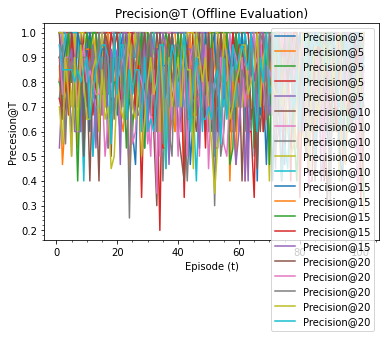

In [58]:
# Offline evaluate

# PMF
for T_precision in T_precisions:
    pmf_Ts = []
    for i in range(5): 
    # for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_pmf_evaluate(T_precision)

        # Append to list
        pmf_Ts.append(avg_precision)

    # Save data
    pmf_Ts = np.array(pmf_Ts)
    np.save(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.npy', pmf_Ts)

    # Save
    sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(pmf_Ts)}', file=sourceFile)
    sourceFile.close()

Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8400 | 
Episode 40 | Precision@5 1.0 | Avg Precision@5 0.8100 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.8033 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.7975 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.8180 | 
Offline Evaluation Finished
Average Precision@5: 0.8198 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8900 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.8350 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.8367 | 
Episode 80 | Precision@5 0.6 | Avg Precision@5 0.8425 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.8500 | 
Offline Evaluation Finished
Average Precision@5: 0.8495 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8600 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.8650 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.8500 | 
Episode 80 | Precision@5 0.8 | Avg Precision@5 0.8350 | 
Episode 100 | Precision@5 0.8 | Avg Precision@5 0.8180 | 
Offline Evaluation Finis

Episode 5 | Precision@20 0.35 | Avg Precision@20 0.7600 | 
Episode 10 | Precision@20 0.6 | Avg Precision@20 0.7200 | 
Episode 15 | Precision@20 0.75 | Avg Precision@20 0.6933 | 
Episode 20 | Precision@20 0.6 | Avg Precision@20 0.6775 | 
Episode 25 | Precision@20 0.85 | Avg Precision@20 0.7040 | 
Episode 30 | Precision@20 0.95 | Avg Precision@20 0.7050 | 
Episode 35 | Precision@20 0.7 | Avg Precision@20 0.7229 | 
Episode 40 | Precision@20 0.8 | Avg Precision@20 0.7238 | 
Episode 45 | Precision@20 0.65 | Avg Precision@20 0.7233 | 
Episode 50 | Precision@20 1.0 | Avg Precision@20 0.7350 | 
Episode 55 | Precision@20 0.6 | Avg Precision@20 0.7409 | 
Episode 60 | Precision@20 0.7 | Avg Precision@20 0.7400 | 
Episode 65 | Precision@20 0.6 | Avg Precision@20 0.7454 | 
Episode 70 | Precision@20 0.45 | Avg Precision@20 0.7364 | 
Episode 75 | Precision@20 0.85 | Avg Precision@20 0.7440 | 
Episode 80 | Precision@20 0.8 | Avg Precision@20 0.7488 | 
Episode 85 | Precision@20 1.0 | Avg Precision@20 0

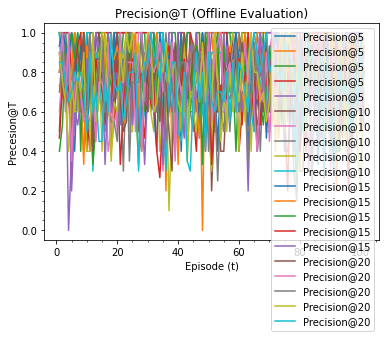

In [59]:
# DRR
for T_precision in T_precisions:
    drr_Ts = []
    for i in range(5):
    #for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_evaluate(T_precision)

        # Append to list
        drr_Ts.append(avg_precision)

    # Save data
    drr_Ts = np.array(drr_Ts)
    np.save(output_path + f'avg_precision@{T_precision}_offline_eval.npy', drr_Ts)

    # Save
    sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(drr_Ts)}', file=sourceFile)
    sourceFile.close()

In [60]:
pmf_fives = np.load(output_path + 'avg_precision@5_offline_pmf_eval.npy')
pmf_tens = np.load(output_path + 'avg_precision@10_offline_pmf_eval.npy')
pmf_fifteens = np.load(output_path + 'avg_precision@15_offline_pmf_eval.npy')
pmf_twenties = np.load(output_path + 'avg_precision@20_offline_pmf_eval.npy')

drr_fives = np.load(output_path + 'avg_precision@5_offline_eval.npy')
drr_tens = np.load(output_path + 'avg_precision@10_offline_eval.npy')
drr_fifteens = np.load(output_path + 'avg_precision@15_offline_eval.npy')
drr_twenties = np.load(output_path + 'avg_precision@20_offline_eval.npy')

[0.9128712871287128, 0.8225742574257427, 0.7922112211221122, 0.7908910891089109]
[0.01252387192145894, 0.01105014370558716, 0.015238235279744515, 0.021915881282015996]
[0.8217821782178216, 0.7487128712871288, 0.7392739273927393, 0.7377227722772278]
[0.015389591467505388, 0.025214694243701433, 0.014836075614084565, 0.014750149328239735]


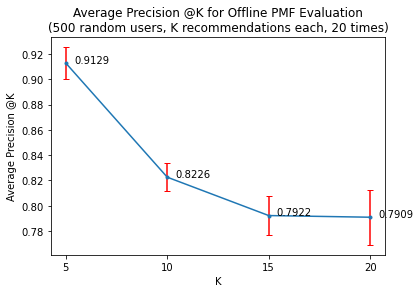

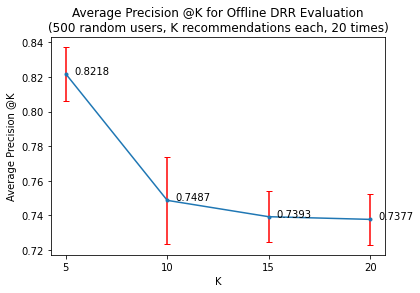

In [62]:
# Evaluation @K Graphing

def createEvalPlot(title, ylabel, xlabel, filename, x, y, e, e_x_off, e_y_off):
    plt.figure()
    plt.errorbar(x, y, yerr=e, fmt='.-', ecolor="red", capsize=3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(x)
    for i, j in zip(x, y):
        plt.annotate(str(round(j, 4)), xy=(i+e_x_off, j+e_y_off))
    plt.savefig(filename)

# Combine data
pmf_offline_eval_data = [pmf_fives, pmf_tens, pmf_fifteens, pmf_twenties]
offline_eval_data = [drr_fives, drr_tens, drr_fifteens, drr_twenties]

# Calculate means and stds for graphing
pmf_offline_means, pmf_offline_stds = [], []
offline_means, offline_stds = [], []
    
for d in pmf_offline_eval_data:
    pmf_offline_means.append(np.mean(d))
    pmf_offline_stds.append(np.std(d))

for d in offline_eval_data:
    offline_means.append(np.mean(d))
    offline_stds.append(np.std(d))

print(pmf_offline_means)
print(pmf_offline_stds)
print(offline_means)
print(offline_stds)


# Create and save eval plots
createEvalPlot("Average Precision @K for Offline PMF Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "pmf_offline_eval.png",
                   T_precisions,
                   pmf_offline_means,
                   pmf_offline_stds,
                   0.4,
                   0)

createEvalPlot("Average Precision @K for Offline DRR Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "offline_eval.png",
                   T_precisions,
                   offline_means,
                   offline_stds,
                   0.4,
                   0)